# Random Forest Final Model - Zeppelin, Svalbard

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config as cfg

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [5]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'ZEP', 'This script is only for Zeppelin, Svalbard. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Zeppelin, Svalbard.


### Loading & Initialising Data

In [6]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
19403,2021-05-11 21:00:00,-8.076770,3.141769,-0.451967,-4.737000,-0.409474,-4.235833,-2.185959,1.690903,-4.924157,...,-0.139386,1.476880,0.921012,1.859929,-1.047732,1.294653,-1.531883,-0.577896,-0.716662,1.0
8812,2016-03-21 19:00:00,-4.885189,1.027302,1.710156,1.239794,-1.893622,2.902387,0.018247,-0.222238,-1.083097,...,0.971536,0.699026,0.224399,-0.566312,1.021531,-0.759151,0.937762,-0.392852,0.140590,1.0
13368,2018-04-22 23:00:00,-1.467411,6.755407,1.151868,3.277006,-3.051861,2.231044,1.770079,1.321675,0.325014,...,0.354589,-1.105344,-1.349598,-1.475982,0.410731,-1.992941,0.899020,0.204058,-0.028706,1.0
9660,2016-08-29 03:00:00,-7.696156,8.690533,6.702520,2.537931,-0.623908,1.349009,-1.149700,2.120134,-0.817523,...,0.829982,-2.937098,-0.524015,0.421136,1.956970,-1.113870,1.784646,0.156663,-0.872388,1.0
4186,2014-01-07 11:00:00,9.170076,-4.315331,-5.209894,0.452565,-3.942273,4.280366,0.990810,3.163220,2.375308,...,-0.208266,-0.258571,-0.025993,-0.745231,-0.278030,0.859083,0.592591,0.900656,0.886074,1.0


In [7]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 23:00:00. Length: 1877
Val range: 2019-01-01 01:00:00 -> 2019-12-30 19:00:00. Length: 2043
Test range: 2020-01-01 17:00:00 -> 2022-12-31 01:00:00. Length: 5767


### Model

In [8]:
# fitting models based on optimal hyperparameters
rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=200,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=False,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.982
Precision on Validation Set = 0.936
Recall on Training Set = 0.832
Recall on Validation Set = 0.766
F1 Score on Training Set = 0.901
F1 Score on Validation Set = 0.842


In [9]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.949
Recall on Test Set = 0.768
F1 Score on Test Set = 0.849


In [10]:
# saving model
dump(rf_model, data_path/f'rf_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_ZEP.joblib']

### Assessing Feature Importance

C:\Users\kirst\AppData\Local\Temp\ipykernel_10488\2727923051.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


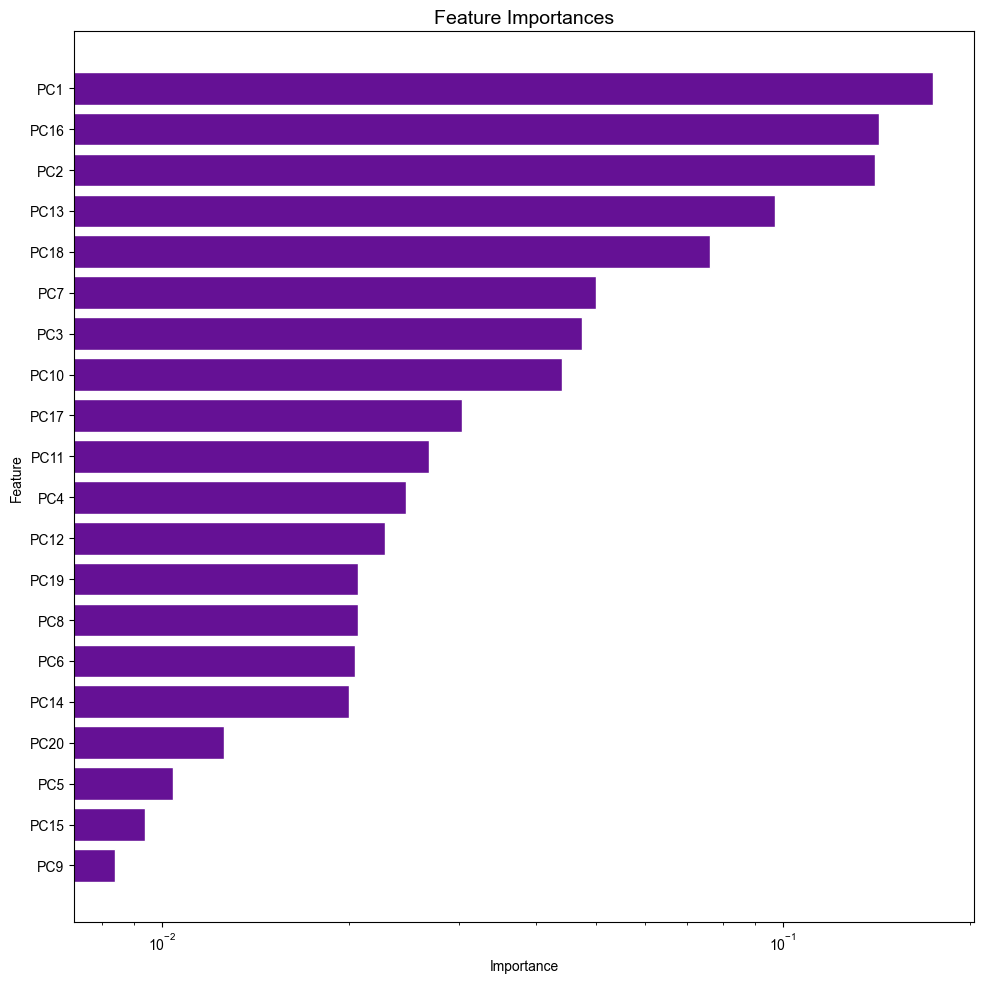

In [11]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style='ticks', font='Arial')

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'], color='#651195')

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [12]:
# identifying the three most important features
top_3_features = feature_importances.sort_values('importance', ascending=False).head(3)
first = top_3_features.index[0]
second = top_3_features.index[1]
third = top_3_features.index[2]

print(f"The three most important features are: \033[1m{first}\033[0;0m, \033[1m{second}\033[0;0m, and \033[1m{third}\033[0;0m.")

The three most important features are: PC1, PC16, and PC2.


In [13]:
# retrieving loadings from model setup
loadings = pd.read_csv(data_path/f'pca_loadings_{compound}_{site}.csv', index_col=0)
loadings

# extracting loadings of top 3 most important PCAs
# based on names of the identified most important PCs
first_pca = loadings[first]
second_pca = loadings[second]
third_pca = loadings[third]

# identifying features with the highest loadings in top 3 PCAs
first_pca = first_pca.abs().sort_values(ascending=False)
second_pca = second_pca.abs().sort_values(ascending=False)
third_pca = third_pca.abs().sort_values(ascending=False)

print(f"Top 5 features in {first}: {first_pca.head(3).index.values}")
print(f"Top 5 features in {second}: {second_pca.head(3).index.values}")
print(f"Top 5 features in {third}: {third_pca.head(3).index.values}")

Top 5 features in PC1: ['v850_8_past' 'v850_1_past' 'v850_1']
Top 5 features in PC16: ['u850_15_past' 'u10_7_past' 'u850_7_past']
Top 5 features in PC2: ['u850_3_past' 'u850_11_past' 'u850_11']


In [14]:
# identifying what position importance blh is in for PCA2, 12 and 11
print(f"Position of 'blh' in {first}: {first_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {second}: {second_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {third}: {third_pca.index.get_loc('blh')}")

Position of 'blh' in PC1: 162
Position of 'blh' in PC16: 69
Position of 'blh' in PC2: 124


Text(0.5, 1.02, 'Feature Importances for PCA Loadings')

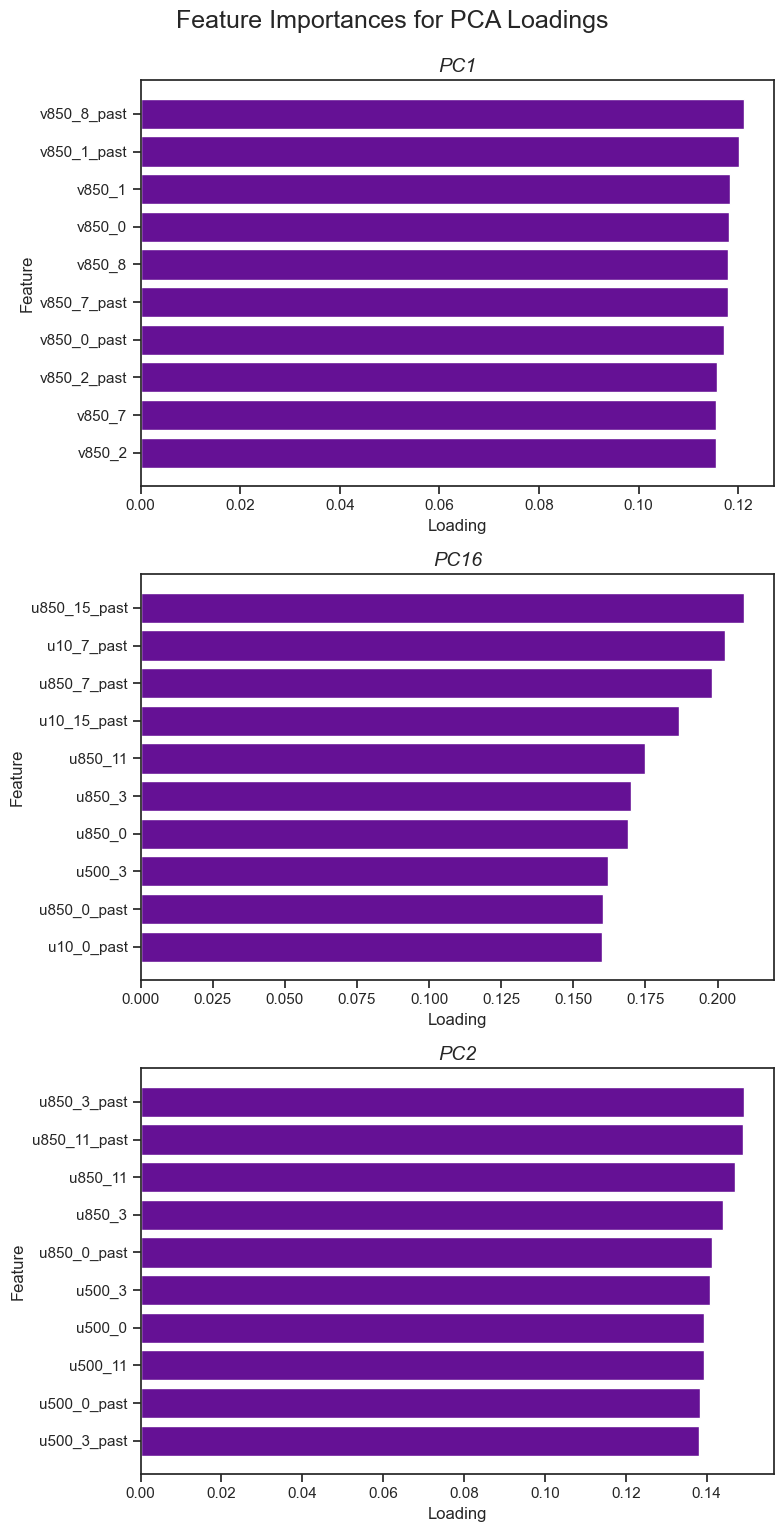

In [15]:
# plotting feature importances for loading of PCA2, 12 and 11
fig, axes = plt.subplots(3,1,figsize=(8, 15))
sns.set_theme(style='ticks', font='Arial')

# filtering feature importances for PCA2 - only including 10 most important features and sorting them
first_pca = first_pca.loc[first_pca.index[:10]].sort_values(ascending=True)
second_pca = second_pca.loc[second_pca.index[:10]].sort_values(ascending=True)
third_pca = third_pca.loc[third_pca.index[:10]].sort_values(ascending=True)

# bar chart of feature importances
axes[0].barh(first_pca.index, first_pca, color='#651195')
axes[1].barh(second_pca.index, second_pca, color='#651195')
axes[2].barh(third_pca.index, third_pca, color='#651195')

# adding titles and labels
axes[0].set_ylabel('Feature')
axes[0].set_xlabel('Loading')
axes[0].set_title(f'{first}', fontsize=14, fontstyle='italic')

axes[1].set_ylabel('Feature')
axes[1].set_xlabel('Loading')
axes[1].set_title(f'{second}', fontsize=14, fontstyle='italic')

axes[2].set_ylabel('Feature')
axes[2].set_xlabel('Loading')
axes[2].set_title(f'{third}', fontsize=14, fontstyle='italic')

fig.tight_layout()
fig.suptitle('Feature Importances for PCA Loadings', fontsize=18, y=1.02)